In [21]:
import torch
import numpy
import torch.nn as nn
from torchvision import transforms
import torchvision.datasets
import matplotlib.pyplot as plt
import math
import torch.utils.data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
train_size = 0.8
val_size = 0.2
generator_gpu = torch.Generator(device=device).manual_seed(42)
generator = torch.Generator().manual_seed(42)

In [23]:
'''def normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    
    return torch.round(tensor)


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:normalization(tensor, 0, 1))
])
'''
def add_noise(img_tensor, std=0.4):
    return (img_tensor + torch.randn(img_tensor.size(), generator=generator_gpu, device=device) * std)

In [24]:
train_data  = torchvision.datasets.MNIST("./data", train=True, transform=transforms.ToTensor(), download=False)
test_data = torchvision.datasets.MNIST("./data", train=False, transform=transforms.ToTensor(), download=False)

data_size = len(train_data)

In [25]:
len(train_data), len(test_data)

(60000, 10000)

In [26]:
train_set, val_set = torch.utils.data.random_split(train_data, [int(train_size*data_size), int(val_size*data_size)], generator=generator)

In [27]:
len(train_set), len(val_set)

(48000, 12000)

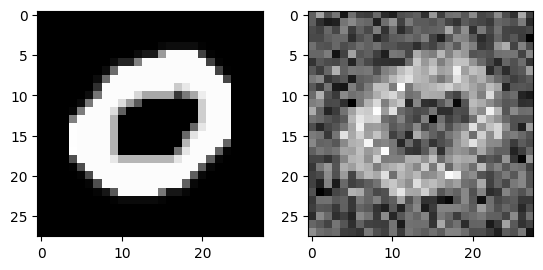

In [28]:
fig, ax = plt.subplots(1, 2)
j = 69
x, _ = train_set[j]
ax[0].imshow(x.numpy()[0], cmap='gray')
ax[1].imshow(add_noise(x.to(device)).cpu().numpy()[0], cmap='gray')

In [29]:
class ConvAE(nn.Module):
    def __init__(self, input_dim = 28, hidden_dim:int = 16, latent_dim:int = 32, kernel_size:int = 3):
        super(ConvAE, self).__init__()

        linear_dim = (hidden_dim) * (input_dim//4) * (input_dim//4)
        pad = (kernel_size - 1) // 2

        self.encoder = nn.Sequential(nn.Conv2d(1, hidden_dim//2, kernel_size=kernel_size, padding=pad),
                                     nn.ReLU(), 
                                     nn.MaxPool2d(2, 2),
                                     nn.Conv2d(hidden_dim//2, hidden_dim, kernel_size=kernel_size, padding=pad),
                                     nn.ReLU(),
                                     nn.MaxPool2d(2, 2),
                                     nn.Flatten(),
                                     nn.Linear(linear_dim, latent_dim),
                                     nn.ReLU()
                                     )
        
        self.decoder = nn.Sequential(nn.Linear(latent_dim, linear_dim),
                                     nn.ReLU(), 
                                     nn.Unflatten(dim=1, unflattened_size=((hidden_dim), (input_dim//4), (input_dim//4))),
                                     nn.ConvTranspose2d(hidden_dim, hidden_dim//2, kernel_size=2, stride=2), 
                                     nn.ConvTranspose2d(hidden_dim//2, 1, kernel_size=2, stride=2), 
                                     nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x) 
    
        return self.decoder(x)

In [30]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set), shuffle=False, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), pin_memory=True)

In [35]:
mode = 'dae'

model = ConvAE(hidden_dim=32, latent_dim=128).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
criterion = torch.nn.BCELoss()
val_criterion = torch.nn.L1Loss()

epochs = 20
for epoch in range(epochs):
    model.train()
    tr_epoch_loss = 0
    for i, (input_img, _) in enumerate(train_loader):
        optimizer.zero_grad()

        input_img = input_img.to(device)
        img_noisy = add_noise(input_img)
        out = model(img_noisy)
        
        tr_loss = criterion(out, input_img)

        tr_loss.backward()
        optimizer.step()

        tr_epoch_loss += tr_loss.item()


    model.eval()
    with torch.no_grad():
        for input_img, _ in val_loader:
            
            input_img = input_img.to(device)
            out = model(input_img)
                
            val_loss = val_criterion(out, input_img)
            bce_val_loss = criterion(out, input_img)

        print(f"epoch [{epoch + 1}/{epochs}], tr_loss: {tr_epoch_loss/(i+1):.4f}, L1_val_loss: {val_loss.item():.4f}, BCE_val_loss: {bce_val_loss.item():.4f}")

epoch [1/20], tr_loss: 0.2782, L1_val_loss: 0.1544, BCE_val_loss: 0.2464
epoch [2/20], tr_loss: 0.1929, L1_val_loss: 0.0913, BCE_val_loss: 0.1667
epoch [3/20], tr_loss: 0.1512, L1_val_loss: 0.0698, BCE_val_loss: 0.1385
epoch [4/20], tr_loss: 0.1373, L1_val_loss: 0.0626, BCE_val_loss: 0.1285
epoch [5/20], tr_loss: 0.1309, L1_val_loss: 0.0579, BCE_val_loss: 0.1218
epoch [6/20], tr_loss: 0.1262, L1_val_loss: 0.0550, BCE_val_loss: 0.1173
epoch [7/20], tr_loss: 0.1223, L1_val_loss: 0.0523, BCE_val_loss: 0.1140
epoch [8/20], tr_loss: 0.1202, L1_val_loss: 0.0502, BCE_val_loss: 0.1109
epoch [9/20], tr_loss: 0.1171, L1_val_loss: 0.0487, BCE_val_loss: 0.1096
epoch [10/20], tr_loss: 0.1162, L1_val_loss: 0.0471, BCE_val_loss: 0.1070
epoch [11/20], tr_loss: 0.1153, L1_val_loss: 0.0484, BCE_val_loss: 0.1092
epoch [12/20], tr_loss: 0.1140, L1_val_loss: 0.0512, BCE_val_loss: 0.1110
epoch [13/20], tr_loss: 0.1131, L1_val_loss: 0.0450, BCE_val_loss: 0.1036
epoch [14/20], tr_loss: 0.1116, L1_val_loss: 0.

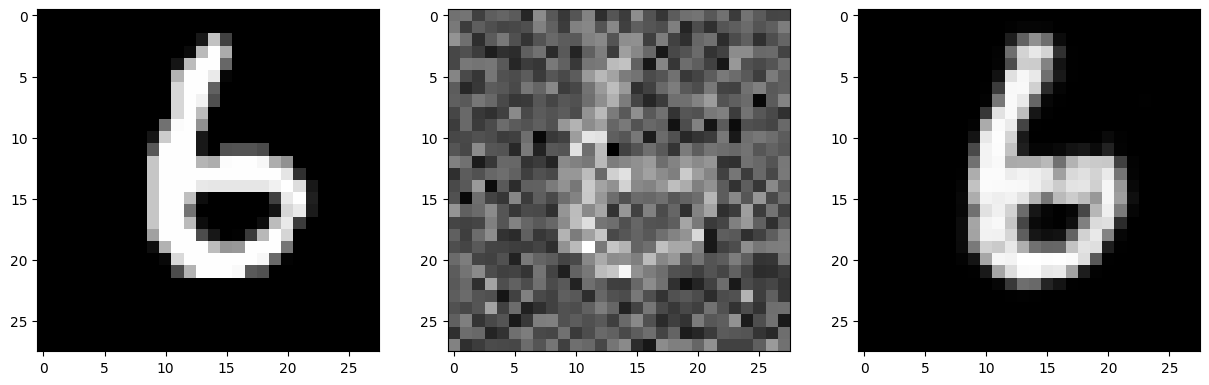

In [36]:
j = 2
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
x, _ = train_set[j]
x_noisy = add_noise(x.to(device))
x_squeeze = x.unsqueeze(0)

with torch.no_grad():
    ax[0].imshow(x.numpy()[0], cmap='gray')
    ax[1].imshow(x_noisy.to('cpu').numpy()[0], cmap='gray')
    out = model(x_noisy.to(device).unsqueeze(0))
    ax[2].imshow(numpy.reshape((out.cpu().numpy()[0]), (28, 28)), cmap='gray')

In [37]:
model.eval()
with torch.no_grad():
    for j, (input_img, _) in enumerate(test_loader):
        input_img = input_img.to(device)
        out = model(input_img)
                
        test_loss = criterion(out, input_img)

    print(f"val_loss: {test_loss.item():.4f}")

val_loss: 0.0991
